In [204]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset


import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [205]:
print(os.getcwd())

C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums


In [206]:
# Declare important variables
train_path = 'train.csv'
solve_path = 'test.csv'
target_variable = 'Premium Amount'
SEED = 69

In [207]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    if socket.gethostname() == 'zchodani-p-l01':
        file_directory = r"C:\Users\zchodaniecky\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    elif socket.gethostname() == 'FTILC3VBil7BwCe':
        file_directory = r"C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
    else:
        file_directory = r"C:\Users\zanec\OneDrive\Documents\Python\Kaggle\Playground Series\s4e12 - Insurance Premiums"
         
    os.chdir(file_directory)

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    return df1, df2

In [208]:
df_train, df_solve = load_dataframes(train_path,solve_path)

In [209]:
df_train_id = df_train['id']
df_train = df_train.drop('id',axis=1)

df_solve_id = df_solve['id']
df_solve = df_solve.drop('id',axis=1)

In [210]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

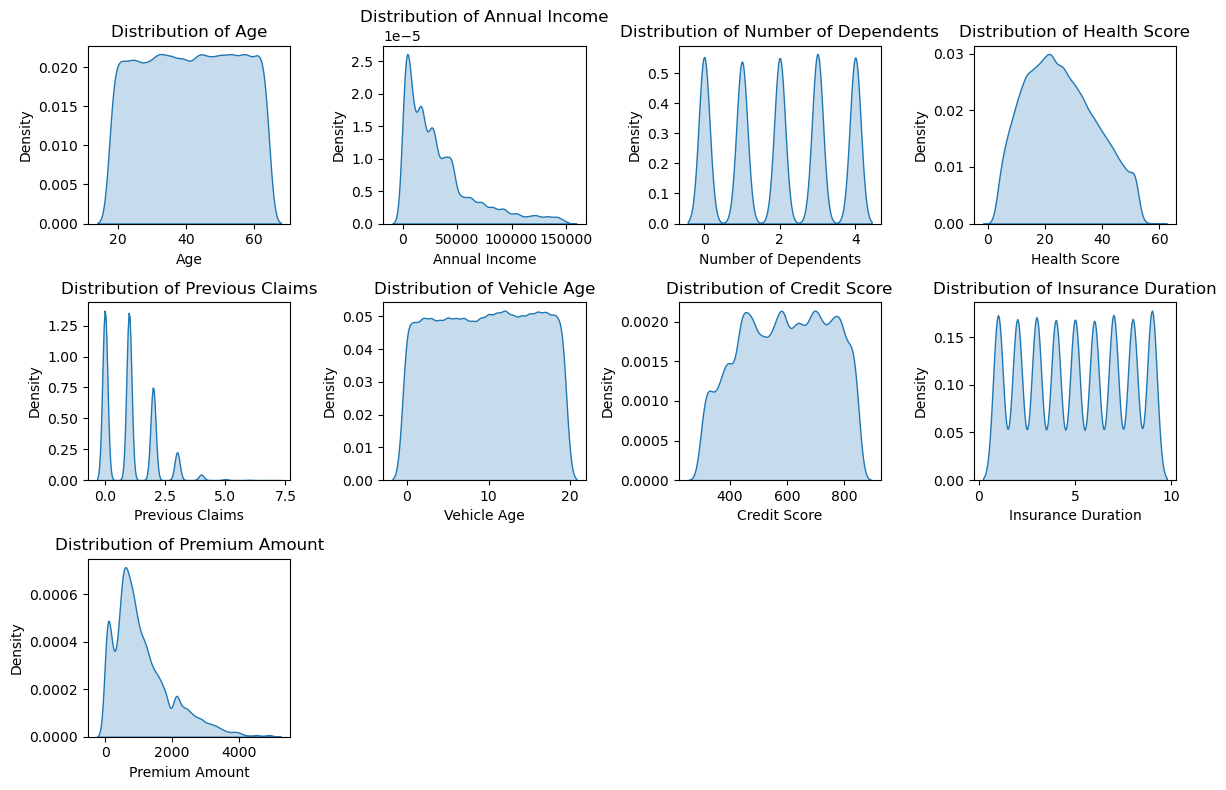

In [211]:
plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

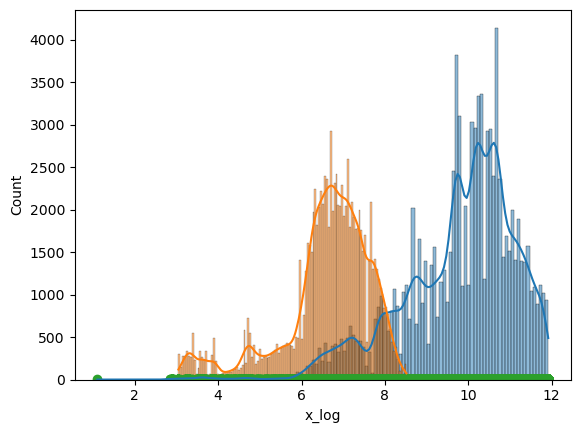

In [212]:
""" Annual Income and Premium Amount look to have some sort of correlation
    and both are right skew, lets look close
"""
df_hist = pd.DataFrame()
df_hist['x_log'] = np.log(df_train['Annual Income'] + 1)   # Add 1 to avoid log(0)
df_hist['y_log'] = np.log(df_train['Premium Amount'] + 1)  # Add 1 to avoid log(0)

# Plot histograms to check for skewness
sns.histplot(df_hist['x_log'], kde=True)
sns.histplot(df_hist['y_log'], kde=True)

# Scatter plot to check correlation between x and y
plt.scatter(df_hist['x_log'], df_hist['y_log'])
plt.show()

In [213]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
    # Plot unique values
    fig, ax = plt.subplots(1, 1, figsize=(24, 5))
    sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
    ax.set_title(f'{name} Unique Values')
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,1540,1.540000,47,0,18.000000,64.000000,41.176000,13.549630,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,3792,3.792000,33760,0,2.000000,149996.000000,32761.461750,32179.156965,nan,nan
3,Marital Status,object,1553,1.553000,3,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,9105,9.105000,5,0,0.000000,4.000000,2.007976,1.415089,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,29818,29.818000,3,0,nan,nan,nan,nan,Employed,23568
7,Health Score,float64,5968,5.968000,76632,0,2.053458,58.886035,25.609103,12.195576,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


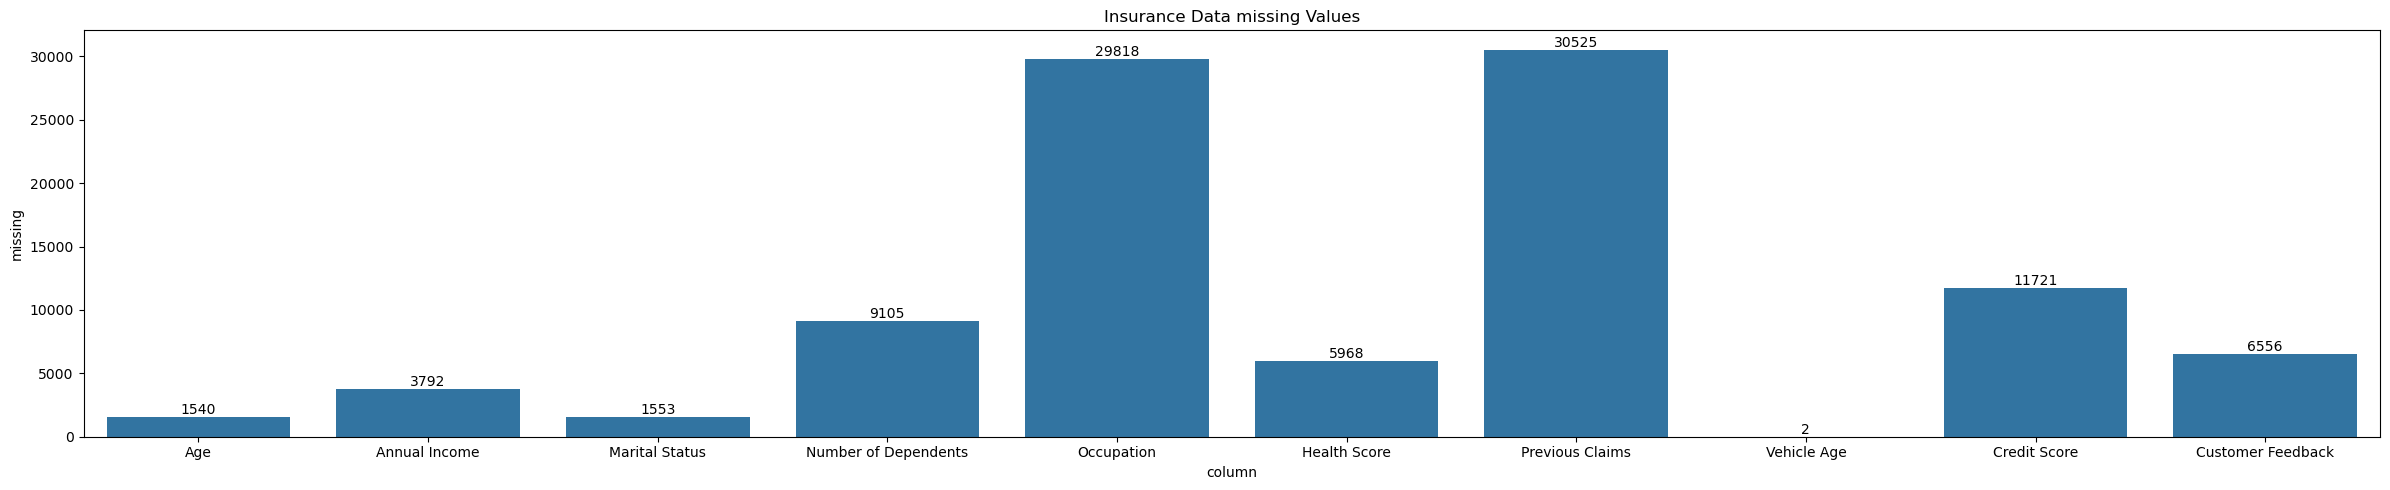

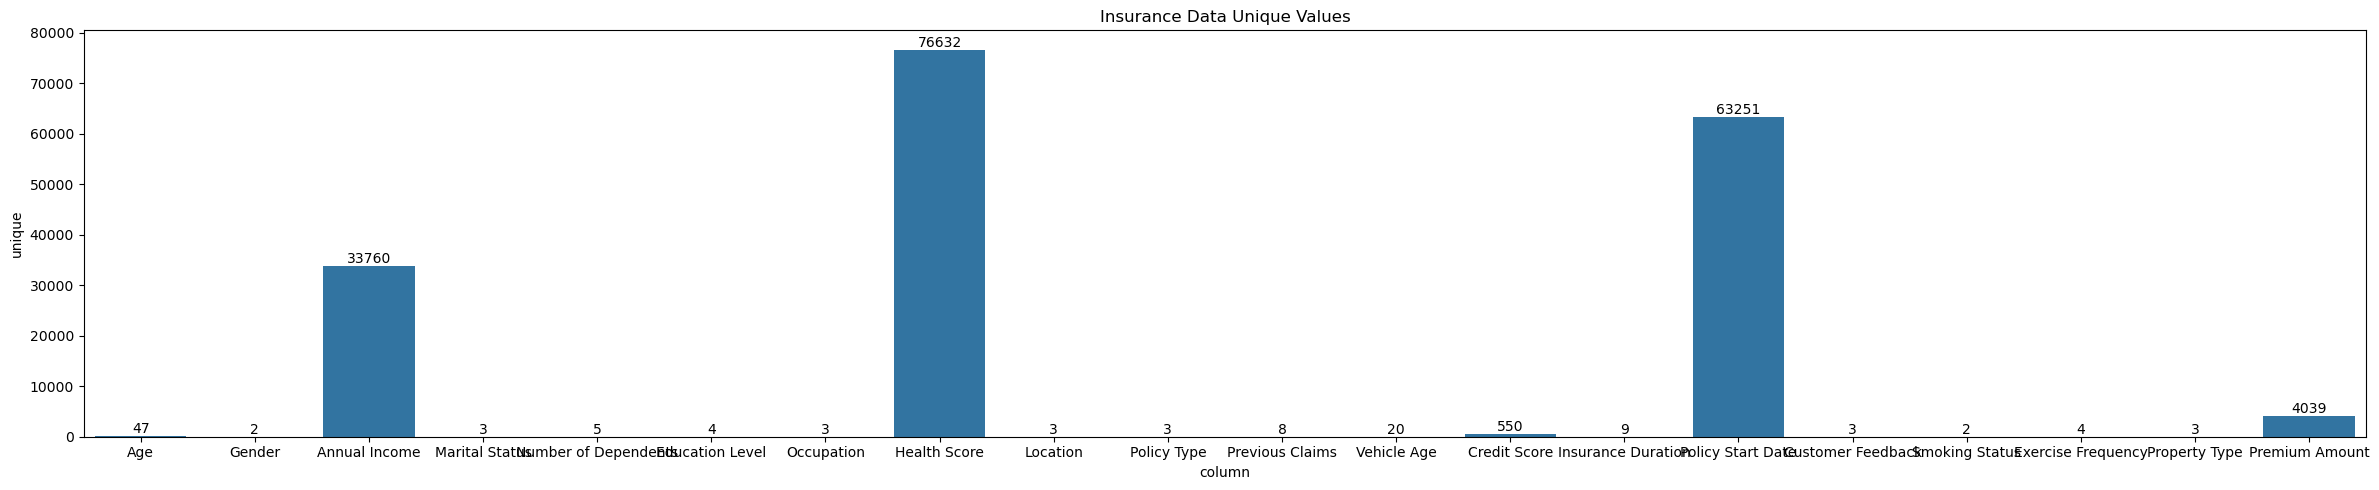

In [214]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=True, info=True)

In [215]:
def clean_dataframe(df_to_use: pd.DataFrame) -> None:
    df = df_to_use.copy()
    
    # inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    # df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})  
    # # Merge the two DataFrames on 'column'
    # inf['missing'] = df_missing['missing'] 
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=[np.float64, np.int64]).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

     # Fill nulls in numeric columns with the median
    for column in missing_numeric_columns:
        mdn = df[column].median()
        df[column] = df[column].fillna(mdn)

    
    # Get object columns
    object_columns = df.select_dtypes(include=['object', 'string']).columns.tolist()  
    # Fill missing values in object columns
    for column in object_columns:
        df[column] = df[column].fillna('Unknown')
    # Convert object columns to string
    #for column in object_columns:
        #df[column] = df[column].astype('string')
    
    return df

In [216]:
df_train_cleaned = clean_dataframe(df_train)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


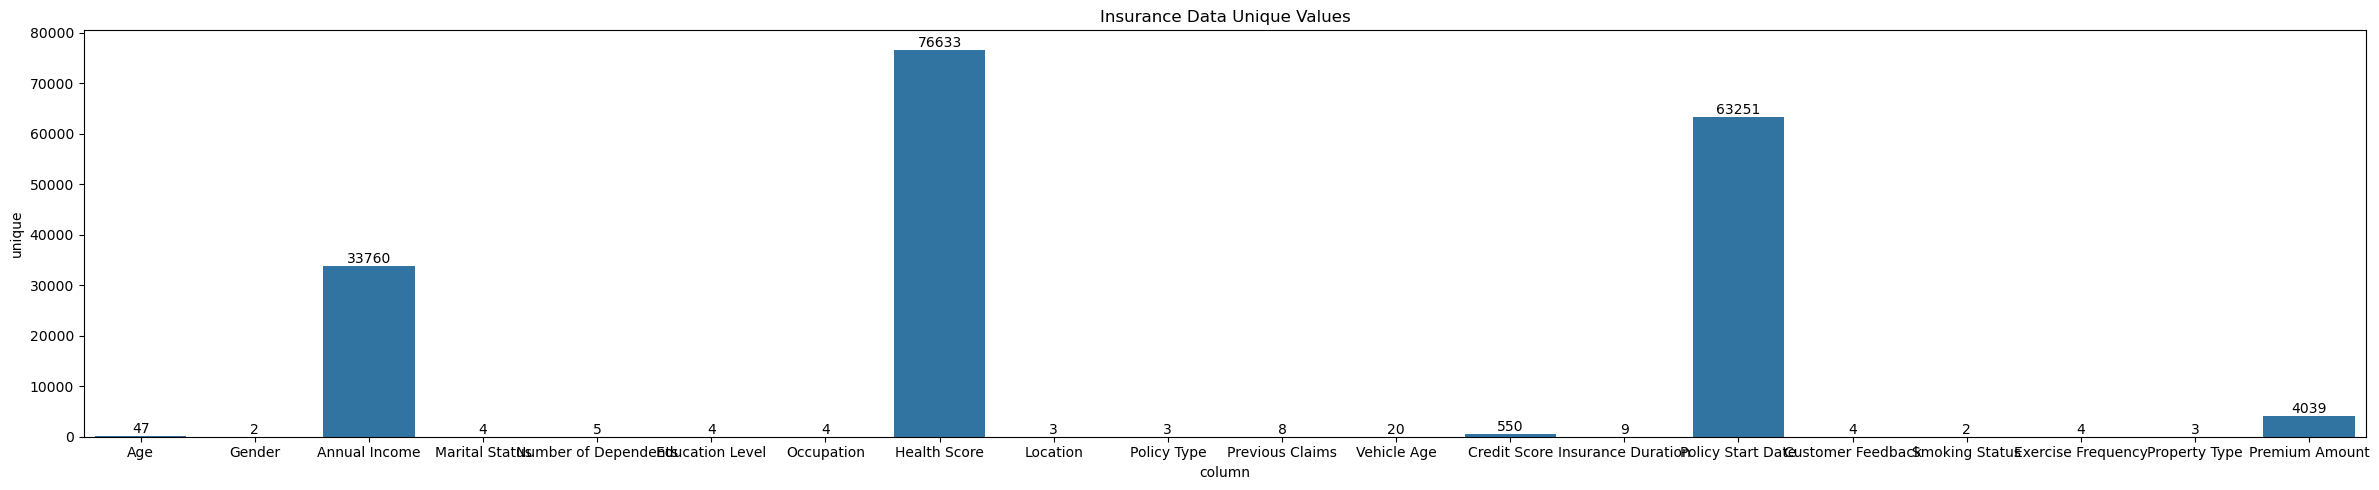

In [217]:
describe_dataframe(df_train_cleaned, name='Insurance Data', nrows=0, plots=True, info=True)

In [218]:
def transform_dataframe(df_to_use: pd.DataFrame) -> None:
    
    df = df_to_use.copy()
    
    # Transform Date Fields
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month Name'] = df['Policy Start Date'].dt.month_name()
    df['Day of Week'] = df['Policy Start Date'].dt.day_name()
    #df['Week'] = df['Policy Start Date'].dt.isocalendar().week.astype('int32')
    df['Year Sin'] = np.sin(2 * np.pi * df['Year'])
    #df['Year Cos'] = np.cos(2 * np.pi * df['Year'])
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day Cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    #df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df = df.drop('Policy Start Date', axis=1)


    # List of columns to encode
    columns_to_encode = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
    ]
    
    # Apply frequency encoding to Categories
    for col in columns_to_encode:
        # Get the column names before encoding
        existing_columns = set(df.columns)
        
        freq_encoding = df[col].value_counts()  # Count occurrences
        # Do not need to encode columns with Cat_Boost
        #df[f'{col}_Freq'] = df[col].map(freq_encoding).astype('int32')  # Map frequencies to the original data
        
        
    #df = df.drop(columns=columns_to_encode, axis=1)
    
    return df

In [219]:
df_train_prepared = transform_dataframe(df_train_cleaned)

,column,type,missing,pct_missing,unique,duplicate,min,max,avg,std dev,top value,Freq
0,Age,float64,0,0.000000,47,0,18.000000,64.000000,41.173290,13.444909,nan,nan
1,Gender,object,0,0.000000,2,0,nan,nan,nan,nan,Male,50407
2,Annual Income,float64,0,0.000000,33760,0,2.000000,149996.000000,32424.942160,31608.620253,nan,nan
3,Marital Status,object,0,0.000000,4,0,nan,nan,nan,nan,Single,33251
4,Number of Dependents,float64,0,0.000000,5,0,0.000000,4.000000,2.007250,1.349131,nan,nan
5,Education Level,object,0,0.000000,4,0,nan,nan,nan,nan,Bachelor's,25374
6,Occupation,object,0,0.000000,4,0,nan,nan,nan,nan,Unknown,29818
7,Health Score,float64,0,0.000000,76633,0,2.053458,58.886035,25.548309,11.828520,nan,nan
8,Location,object,0,0.000000,3,0,nan,nan,nan,nan,Suburban,33628
9,Policy Type,object,0,0.000000,3,0,nan,nan,nan,nan,Premium,33844


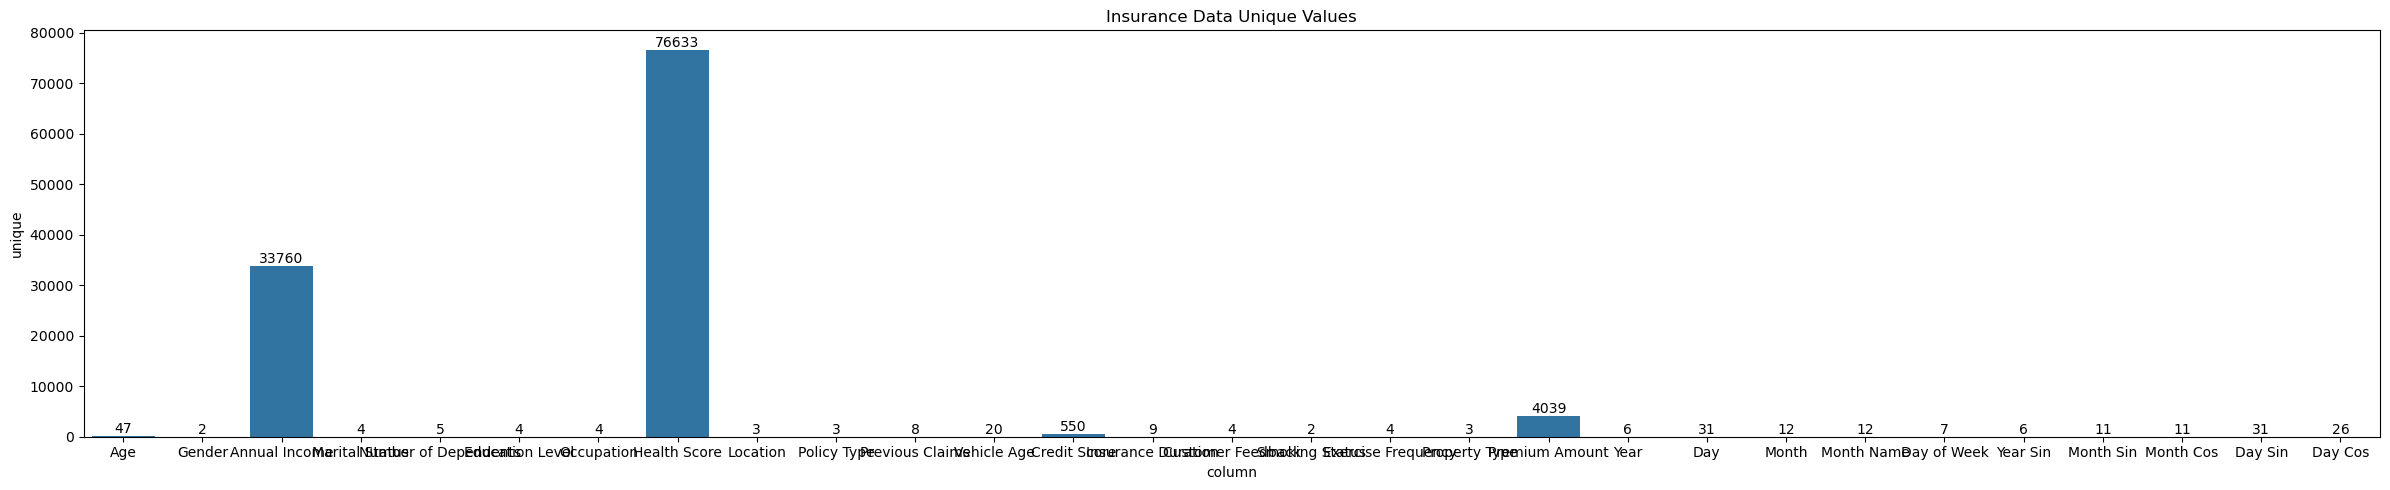

In [220]:
describe_dataframe(df_train_prepared, name='Insurance Data', nrows=0, plots=True, info=True)

In [221]:
#sns.heatmap(df_train_prepared.corr(), annot=False, cmap='magma')
"""
Positive Corr: 
    Credit Score / Annual Income
    Premium Amount / Previous Claims
    Year / Group (too high, should remove)
    Week / Month (too high, should remove)
"""

'\nPositive Corr: \n    Credit Score / Annual Income\n    Premium Amount / Previous Claims\n    Year / Group (too high, should remove)\n    Week / Month (too high, should remove)\n'

In [222]:
from sklearn.model_selection import train_test_split

# Split into 80% training data and 20% testing data

X = df_train_prepared.drop('Premium Amount', axis=1)
y = df_train_prepared['Premium Amount'].copy()

X_train_initial, X_test, y_train_initial, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Now split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_initial, y_train_initial, test_size=0.25, random_state=SEED)


y_log_train = np.log1p(y_train)
y_log_val = np.log1p(y_val)
y_log_test = np.log1p(y_test)

In [223]:
# Pipeline constructor used to run transformation steps in order
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numeric_cols = X.select_dtypes(include=[np.float64, np.int64, np.int32]).columns

# Define a ColumnTransformer for scaling numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough'
)

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Fit and transform training data
X_train_prepared= pipeline.fit_transform(X_train)

# Transform validation and test data usingthe same pipeline
X_val_prepared= pipeline.transform(X_val)
X_test_prepared= pipeline.transform(X_test)


In [224]:
from keras import backend as K
from sklearn.metrics import mean_squared_log_error

#Define a custom RMSLE metric
def rmsle(y_true, y_pred):  
    # To avoid log(0), clip values to a small positive constant (epsilon)
    epsilon = tf.keras.backend.epsilon()

    # Apply log transformation
    #y_true_log = tf.math.log1p(y_true)  # Log-transform the true values
    #y_pred_log = tf.math.log1p(y_pred)  # Log-transform the clipped predicted values
    
    # RMSLE formula
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [225]:
from tensorflow import keras
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [239]:
# Identify columns with numeric values
numeric_columns = X.select_dtypes(include=[float, int]).columns

# Check if any numeric columns have values that shouldn't be numeric (e.g., should be categorical)
for col in numeric_columns:
    # Check if there are any non-integer values that shouldn't be in a categorical column
    if X[col].apply(lambda x: isinstance(x, (float, int)) and not isinstance(x, int)).any():
        print(f"Column '{col}' has invalid non-integer values. Checking rows...")
        
        # Find rows where the problematic value exists
        problematic_rows = X[X[col].apply(lambda x: isinstance(x, float) and not x.is_integer())]
        
        print(problematic_rows)

Column 'Age' has invalid non-integer values. Checking rows...
Empty DataFrame
Columns: [Age, Gender, Annual Income, Marital Status, Number of Dependents, Education Level, Occupation, Health Score, Location, Policy Type, Previous Claims, Vehicle Age, Credit Score, Insurance Duration, Customer Feedback, Smoking Status, Exercise Frequency, Property Type, Year, Day, Month, Month Name, Day of Week, Year Sin, Month Sin, Month Cos, Day Sin, Day Cos]
Index: []

[0 rows x 28 columns]
Column 'Annual Income' has invalid non-integer values. Checking rows...
Empty DataFrame
Columns: [Age, Gender, Annual Income, Marital Status, Number of Dependents, Education Level, Occupation, Health Score, Location, Policy Type, Previous Claims, Vehicle Age, Credit Score, Insurance Duration, Customer Feedback, Smoking Status, Exercise Frequency, Property Type, Year, Day, Month, Month Name, Day of Week, Year Sin, Month Sin, Month Cos, Day Sin, Day Cos]
Index: []

[0 rows x 28 columns]
Column 'Number of Dependents' 

In [226]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# Parameter grid
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [5, 6, 7]
}


category_columns = [
        'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
        'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
        'Property Type','Month Name','Day of Week'
        ]
category_indicies = [X.columns.get_loc(col) for col in category_columns]


# Assuming X_train_prepared is a numpy array, convert it to DataFrame
X_train_df = pd.DataFrame(X_train_prepared, columns=X.columns)

X_train_prepared.dtype

cat_boost = CatBoostRegressor(random_state=SEED)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_boost,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Output progress messages
    n_jobs=-1  # Use all available cores
)

grid_search.fit(X_train_df, y_log_train,cat_features = category_columns)
best_params = grid_search.best_params_

print("Best parameters:",best_params)
print("Best RMSE:", (-grid_search.best_score_)**0.5)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


ValueError: 
All the 36 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 0.06138602190841397

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=0.06138602190841397 : cat_features must be integer or string, real number values and NaN values should be converted to string.

--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2613, in _catboost.get_cat_factor_bytes_representation
  File "_catboost.pyx", line 2128, in _catboost.get_id_object_bytes_string_representation
_catboost.CatBoostError: bad object for id: 1.3004462777608894

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\catboost\core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3100, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2620, in _catboost.get_cat_factor_bytes_representation
_catboost.CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=1.3004462777608894 : cat_features must be integer or string, real number values and NaN values should be converted to string.


In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_)**0.5)

In [ ]:

# Initialize the LGBMRegressor
cat_boost = CatBoostRegressor(
    **best_params,
    random_state=SEED        # Ensure reproducibility
)

# Train the model
cat_boost.fit(
    X_train_prepared, 
    y_log_train, 
    eval_set=[(X_val_prepared, y_log_val)], 
    eval_metric='rmse',        # Evaluation metric (root mean squared error)
    callbacks=[lgb.early_stopping(50)]  # Stop early if no improvement
)

In [ ]:
# Plot feature importance
import matplotlib.pyplot as plt

feature_importances = cat_boost.get_feature_importance()
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

In [ ]:
# Predict on test set
y_test_pred = cat_boost.predict(X_test_prepared)

In [ ]:
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE
rmse = root_mean_squared_error(y_log_test, y_test_pred)
print(f"RMSE: {rmse:.5f}")

In [ ]:
# Create final predictions
df_solve_cleaned = clean_dataframe(df_solve)
df_solve_prepared = transform_dataframe(df_solve_cleaned)
X_solve_prepared= pipeline.transform(df_solve_prepared)


y_log_solve = cat_boost.predict(df_solve_prepared)

y_solve = np.expm1(y_log_solve)  # Inverse of log1p (to get the original scale)

df_y_solve = pd.DataFrame(y_solve, columns=['Premium Amount'])
df_final = pd.merge(df_solve_id, df_y_solve, left_index=True, right_index=True, how='inner')
df_final.to_csv('Predictions.csv', index=False)

df_final['Premium Amount'].hist()

In [ ]:
# Recent RMSE = 1.05211

In [ ]:
# BEST RMSE = 1.05202